In this notebook, I will be exploring a dataset of 311 complaints in New York City, focusing on complaints related to syringe litter. I would like to investigate the factors driving syringe complaints.

# Data cleaning and feature engineering

In [1]:
# Import libraries
import geopandas as gpd
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
# Download all of the 311 complaints in 2022
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022)%20LIMIT%2050000000')
all_311_complaints.head(2)

,unique_key,created_date,complaint_type,descriptor,longitude,latitude
0,56124390,2022-11-30T14:55:37.000,Damaged Tree,Entire Tree Has Fallen Down,-73.776257,40.786568
1,56125061,2022-11-30T08:11:47.000,Dead Animal,Other,-73.820463,40.838024


In [3]:
# Rename 'created_date' to 'created_datetime', convert it to a datetime
# Then extract date and month
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})
all_311_complaints['created_datetime'] = pd.to_datetime(all_311_complaints['created_datetime'])
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month

In [4]:
# Keep only the rows that have latitude and longitude data
all_311_complaints = all_311_complaints[(pd.isna(all_311_complaints['longitude']) == False) & (pd.isna(all_311_complaints['latitude']) == False)]

In [5]:
# Remove 'duplicate' reports, i.e., reports with the same date, complaint_type, descriptor, latitude, and longitude
all_311_complaints = all_311_complaints.drop_duplicates(subset = ['created_date', 'complaint_type', 'descriptor', 'latitude', 'longitude'])
all_311_complaints = all_311_complaints.reset_index(drop = True)

In [6]:
# Turn all_311_complaints into a GeoDataFrame
all_311_complaints = gpd.GeoDataFrame(all_311_complaints, geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude), crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(epsg=2263) # projection = NAD83 / New York Long Island

In [7]:
all_311_complaints.head(2)

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,geometry
0,56124390,2022-11-30 14:55:37,Damaged Tree,Entire Tree Has Fallen Down,-73.776257,40.786568,2022-11-30,11,POINT (1046209 225924.014)
1,56125061,2022-11-30 08:11:47,Dead Animal,Other,-73.820463,40.838024,2022-11-30,11,POINT (1033929 244643.014)


I had originally planned to analyze the complaints by city council district (CCD), but I decided to base my analysis on neighborhood tabulation area (NTA) instead because there are 5 times as many NTAs, and therefore more samples to train the model on.

In [8]:
# Download the neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

--2025-04-16 00:33:00--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.12.81.170, 2600:1408:ec00:1089::1500, 2600:1408:ec00:1082::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.12.81.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  --.-KB/s    in 0.01s   

2025-04-16 00:33:00 (63.9 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


In [9]:
# Load the neighborhood tabulation area data
nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp')
nta = nta.to_crs(2263)
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


In [10]:
# Create a new column for the NTA area in square miles
nta['area_sq_mi'] = nta['Shape_Area'] / 27878400

In [12]:
# Perform a spatial join to link each 311 complaint with a neighborhood tabulation area
all_311_complaints = gpd.sjoin(all_311_complaints, nta[['NTA2020', 'area_sq_mi', 'geometry']], how = 'left')

In [13]:
all_311_complaints.head(2)

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,geometry,index_right,NTA2020,area_sq_mi
0,56124390,2022-11-30 14:55:37,Damaged Tree,Entire Tree Has Fallen Down,-73.776257,40.786568,2022-11-30,11,POINT (1046209 225924.014),187.0,QN0703,1.410250
1,56125061,2022-11-30 08:11:47,Dead Animal,Other,-73.820463,40.838024,2022-11-30,11,POINT (1033929 244643.014),102.0,BX1003,1.266564


In [ ]:
# For each complaint in all_311_complaints, test whether that complaint correlates with syringe complaints
for complaint in list(set(all_311_complaints['complaint_type'])):
  complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                           syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                           other_complaints = ('complaint_type', lambda x: (x == complaint).sum()))

  test_corr = stats.pearsonr(complaints_by_nta['syringe_complaints']/complaints_by_nta['all_complaints'],
                             complaints_by_nta['other_complaints']/complaints_by_nta['all_complaints'])
  if (test_corr[0] > 0.4) & (test_corr[1] < 0.01):
    print(complaint, test_corr)

Encampment PearsonRResult(statistic=np.float64(0.5114720329150472), pvalue=np.float64(1.143732495965466e-18))
Panhandling PearsonRResult(statistic=np.float64(0.42284913809933644), pvalue=np.float64(1.1737370051832548e-12))
Mold PearsonRResult(statistic=np.float64(0.4413333076335459), pvalue=np.float64(9.025424059750042e-14))


I will explore encampment complaints further, since those have the most correlation with syringe complaints.

In [14]:
# Group all_311_complaints by NTA and calculate the number of all 311 complaints, the number of syringe complaints, and the number of encampment complaints for each one
complaints_nta = all_311_complaints.groupby('NTA2020').agg(area_sq_mi = ('area_sq_mi', 'mean'),
                                                           all_complaints = ('unique_key', 'count'),
                                                           syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                           encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()))
complaints_nta = complaints_nta.reset_index()

In [17]:
# Download the dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [18]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

In [19]:
# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [20]:
# Turn the dropoff_sites DataFrame into a GeoDataFrame
dropoff_sites = gpd.GeoDataFrame(dropoff_sites, geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude), crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(epsg=2263)

In [21]:
# For each NTA, generate 100 random points
nta_random_points = gpd.GeoDataFrame()
nta_random_points['NTA2020'] = nta['NTA2020']
nta_random_points['random_points'] = nta['geometry'].sample_points(100, method='uniform', rng = 212)
nta_random_points = nta_random_points.set_index('NTA2020')
nta_random_points = nta_random_points['random_points'].explode(ignore_index = False).reset_index()

# For each random point, calculate the distance in miles to the nearest sharps dropoff site
nta_random_points['nearest_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites.distance(x).min()).round(0)
nta_random_points['nearest_dropoff_dist_mi'] = nta_random_points['nearest_dropoff_dist_ft'] / 5280

# Group the rows by NTA and get the average distance to the nearest dropoff site
nta_random_points = nta_random_points.groupby('NTA2020').agg(nearest_dropoff_dist_mi = ('nearest_dropoff_dist_mi', 'mean')).reset_index()

In [22]:
# Join the DataFrames to get the number of complaints and the average distance to the nearest sharps dropoff site in one DataFrame
complaints_nta = complaints_nta.merge(nta_random_points[['NTA2020', 'nearest_dropoff_dist_mi']], on = 'NTA2020')

In [23]:
# Divide syringe complaints and encampment complaints by all complaints to normalize them
complaints_nta['syringes / all'] = complaints_nta['syringe_complaints'] / complaints_nta['all_complaints']
complaints_nta['encampments / all'] = complaints_nta['encampment_complaints'] / complaints_nta['all_complaints']

In [28]:
# Divide all complaints, syringe complaints, and encampment complaints by NTA area
complaints_nta['all_complaints_per_sq_mi'] = complaints_nta['all_complaints'] / complaints_nta['area_sq_mi']
complaints_nta['syringe_complaints_per_sq_mi'] = complaints_nta['syringe_complaints'] / complaints_nta['area_sq_mi']
complaints_nta['encampment_complaints_per_sq_mi'] = complaints_nta['encampment_complaints'] / complaints_nta['area_sq_mi']

In [30]:
complaints_nta.columns

Index(['NTA2020', 'area_sq_mi', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'nearest_dropoff_dist_mi', 'syringes / all',
       'encampments / all', 'all_complaints_per_sq_mi',
       'syringe_complaints_per_sq_mi', 'encampment_complaints_per_sq_mi'],
      dtype='object')

In [31]:
# View the correlation matrix
complaints_nta[['area_sq_mi', 'all_complaints', 'syringe_complaints', 'encampment_complaints', 'nearest_dropoff_dist_mi', 'syringes / all', 'encampments / all',
                'all_complaints_per_sq_mi', 'syringe_complaints_per_sq_mi', 'encampment_complaints_per_sq_mi']].corr()

,area_sq_mi,all_complaints,syringe_complaints,encampment_complaints,nearest_dropoff_dist_mi,syringes / all,encampments / all,all_complaints_per_sq_mi,syringe_complaints_per_sq_mi,encampment_complaints_per_sq_mi
area_sq_mi,1.000000,0.087513,-0.044776,-0.112869,0.457633,-0.069186,-0.195020,-0.287872,-0.135922,-0.178920
all_complaints,0.087513,1.000000,0.431250,0.410065,-0.275020,0.190524,0.148384,0.750591,0.379223,0.298029
syringe_complaints,-0.044776,0.431250,1.000000,0.684211,-0.164849,0.712423,0.500955,0.392304,0.932964,0.606119
encampment_complaints,-0.112869,0.410065,0.684211,1.000000,-0.209111,0.494969,0.835175,0.422689,0.720480,0.925486
nearest_dropoff_dist_mi,0.457633,-0.275020,-0.164849,-0.209111,1.000000,-0.175902,-0.213560,-0.397340,-0.193787,-0.216255
syringes / all,-0.069186,0.190524,0.712423,0.494969,-0.175902,1.000000,0.511472,0.215021,0.714993,0.489714
encampments / all,-0.195020,0.148384,0.500955,0.835175,-0.213560,0.511472,1.000000,0.283039,0.600402,0.897217
all_complaints_per_sq_mi,-0.287872,0.750591,0.392304,0.422689,-0.397340,0.215021,0.283039,1.000000,0.470010,0.452761
syringe_complaints_per_sq_mi,-0.135922,0.379223,0.932964,0.720480,-0.193787,0.714993,0.600402,0.470010,1.000000,0.731856
encampment_complaints_per_sq_mi,-0.178920,0.298029,0.606119,0.925486,-0.216255,0.489714,0.897217,0.452761,0.731856,1.000000


We would expect to see a correlation between syringe complaints and the distance to the nearest sharps dropoff site. However, that does not really appear to be the case. There are several possible explanations for this:
* We need to normalize the complaints data differently, e.g., complaints per capita.
*   We are not taking into account the opening hours of the dropoff sites, so nta_dropoff_dist_ft is not a real measure of sharps dropoff site availability. Similarly, there could be other barriers preventing people from going to dropoff sites even if they are nearby and open.
*   Syringe complaints are not a great measure of the amount of syringe litter, but rather a measure of how bothered people are about it. Therefore, the number of 311 complaints might correlate more with something like wealth inequality.



In [32]:
# Load the ACS data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip -O acs.zip
!unzip acs.zip

--2025-04-16 00:42:14--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.13.151.131, 2600:1408:20:68e::1500, 2600:1408:20:68a::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.13.151.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389208 (9.0M) [application/zip]
Saving to: ‘acs.zip’

acs.zip             100%[===================>]   8.95M  --.-KB/s    in 0.05s   

2025-04-16 00:42:14 (195 MB/s) - ‘acs.zip’ saved [9389208/9389208]

Archive:  acs.zip
   creating: 5-yr ACS 2022/CityCouncilDistrict/
   creating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/Dem_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Economic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Economic/Econ_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Housing/
  inflating

In [33]:
# Load the ACS demographic data for NTAs
acs_demographic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Demographic/Dem_1822_NTA.xlsx')
acs_demographic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,...,AsnOAsnE,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,38260,1664.0,2.6,100.0,0.0,...,9,13.0,87.8,0.5,0.7,143,114.0,48.5,7.5,5.8
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,64311,2670.0,2.5,100.0,0.0,...,30,43.0,87.1,0.6,0.8,190,137.0,43.9,3.6,2.5


In [34]:
# Rename 'GeoID' to 'NTA2020'
acs_demographic = acs_demographic.rename(columns = {'GeoID': 'NTA2020'})

In [35]:
# Keep just the Pop_1E column, which represents the population estimate for each NTA
acs_demographic_subset = acs_demographic[['NTA2020', 'Pop_1E']]

In [36]:
# Join complaints_nta and acs_demographic_subset
complaints_nta = complaints_nta.merge(acs_demographic_subset, on = 'NTA2020')

One problem with the population data is that some of the NTAs have populations of 0, e.g., Central Park. Therefore I will add a variable called 'residents' which equals 0 for NTAs with a population of 0 and 1 for the other NTAs. I will also calculate complaints / population + 1 so I don't end up with an infinite number of complaints per capita for some NTAs.

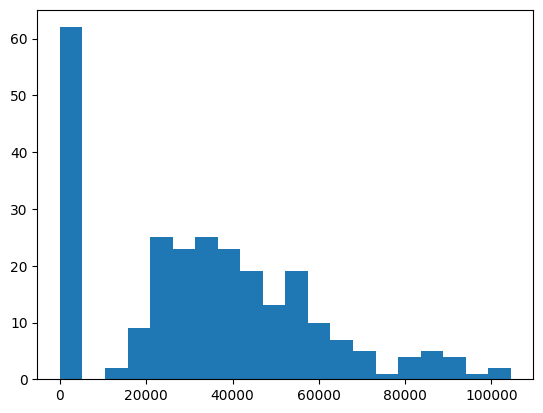

In [43]:
# Make a histogram of Pop_1E
plt.hist(complaints_nta['Pop_1E'], bins = 20)
plt.show()

In [44]:
# Make a column called 'residents' which equals 0 for NTAs with a population of 0 and 1 for the rest
complaints_nta['residents'] = np.where(complaints_nta['Pop_1E'] == 0, 0, 1)

# Get the number of all complaints, syringe complaints, and encampment complaints per capita
# Note: added 1 to population to avoid infinite complaints per capita
complaints_nta['all_complaints_per_capita'] = complaints_nta['all_complaints'] / (complaints_nta['Pop_1E'] + 1)
complaints_nta['syringe_complaints_per_capita'] = complaints_nta['syringe_complaints'] / (complaints_nta['Pop_1E'] + 1)
complaints_nta['encampment_complaints_per_capita'] = complaints_nta['encampment_complaints'] / (complaints_nta['Pop_1E'] + 1)

I would like to test whether syringe complaints are driven by wealth inequality. Therefore, I will focus on the following variables from the ACS datasets:

From the Economic data:
* CvLFUEm1P: the percent of the labor force that is unemployed
* MdHHIncE: the median household income
* PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
* Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00

From the Housing data:
* VacHUP: the percent of vacant housing units
* ROcHU1P: the percent of renter-occupied housing units (as opposed to owner-occupied)
* GRPI30plP: the percent of occupied units where rent is 30% or more of the household income

In [45]:
# Load the ACS economic data for NTAs
acs_economic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Economic/Econ_1822_NTA.xlsx')
acs_economic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,33601,1431.0,2.6,100.0,0.0,...,4404,592.0,8.2,11.6,1.5,20096,1295.0,3.9,52.8,2.5
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,53760,2115.0,2.4,100.0,0.0,...,4381,656.0,9.1,6.8,1.0,29900,1629.0,3.3,46.6,1.6


In [46]:
# Rename 'GeoID' to 'NTA2020'
acs_economic = acs_economic.rename(columns = {'GeoID': 'NTA2020'})

In [47]:
# Keep only the columns that we'll use in the model
acs_economic = acs_economic[['NTA2020', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP']]

In [48]:
# Join complaints_nta and acs_economic
complaints_nta = complaints_nta.merge(acs_economic, on = 'NTA2020')

In [50]:
# Load the ACS housing data for NTAs
acs_housing = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Housing/Hous_1822_NTA.xlsx')
acs_housing.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,HU1E,HU1M,HU1C,HU1P,HU1Z,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,19564,652.0,2.0,100.0,0.0,...,2434,444.0,11.1,17.1,3.0,548,172.0,19.1,NaN,NaN
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,30539,938.0,1.9,100.0,0.0,...,4547,526.0,7.0,19.9,2.1,616,193.0,19.1,NaN,NaN


In [51]:
# Rename 'GeoID' to 'NTA2020'
acs_housing = acs_housing.rename(columns = {'GeoID': 'NTA2020'})

In [52]:
# Keep only the columns that we'll use in the model
acs_housing = acs_housing[['NTA2020', 'VacHUP', 'ROcHU1P', 'GRPI30plP']]

In [53]:
# Join complaints_nta and acs_housing
complaints_nta = complaints_nta.merge(acs_housing, on = 'NTA2020')

I would also like to see whether syringe complaints correlate with tourism. For lack of a better dataset, I will try using the number of hotels as a measure of tourism.

In [68]:
# Load the hotel data
hotels = pd.read_csv('https://data.cityofnewyork.us/resource/tjus-cn27.csv?$limit=5000')
hotels.head(2)

,parid,borocode,block,lot,taxyear,street_num,street_name,postcode,bldg_class,taxclass,...,borough,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,nta_code2
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN


In [74]:
# Remove duplicate hotels (hotels with same address and owner)
hotels = hotels.drop_duplicates(subset = ['street_num', 'street_name', 'postcode', 'owner_name'])
hotels = hotels.reset_index(drop = True)

In [75]:
# Keep only the relevant columns
hotels = hotels[['parid', 'latitude', 'longitude']]

In [76]:
# Keep only the rows with latitude and longitude data
hotels = hotels[(pd.isna(hotels['longitude']) == False) & (pd.isna(hotels['latitude']) == False)]

In [77]:
# Turn hotels into a GeoDataFrame
hotels = gpd.GeoDataFrame(hotels, geometry = gpd.points_from_xy(hotels['longitude'], hotels['latitude']), crs = 'EPSG:4326')
hotels = hotels.to_crs(epsg=2263)

In [78]:
# Join hotels with nta and then group by NTA2020 to find the number of hotels in each NTA
hotels = gpd.sjoin(hotels, nta[['NTA2020', 'geometry', 'Shape_Area']], how = 'left')
hotels_nta = hotels.groupby('NTA2020').agg(hotel_count = ('parid', 'count'),
                                           nta_area = ('Shape_Area', 'mean')).reset_index()

In [84]:
# Calculate the hotels per square mile
# Note that nta_area is in square feet
hotels_nta['hotels_per_sq_mi'] = hotels_nta['hotel_count'] / (hotels_nta['nta_area'] / 27878400)

In [85]:
# Join hotels_nta with complaints_nta
complaints_nta = complaints_nta.merge(hotels_nta[['NTA2020', 'hotels_per_sq_mi']], on = 'NTA2020')

In [86]:
complaints_nta.sort_values(by = 'hotels_per_sq_mi')

,NTA2020,area_sq_mi,all_complaints,syringe_complaints,encampment_complaints,nearest_dropoff_dist_mi,syringes / all,encampments / all,all_complaints_per_sq_mi,syringe_complaints_per_sq_mi,...,syringe_complaints_per_capita,encampment_complaints_per_capita,CvLFUEm1P,MdHHIncE,PvU50P,Pv500plP,VacHUP,ROcHU1P,GRPI30plP,hotels_per_sq_mi
140,SI0304,6.471902,11508,1,8,4.978600,0.000087,0.000695,1778.147963,0.154514,...,0.000023,0.000187,2.1,112914.0,2.7,51.1,5.3,20.6,63.6,0.154514
134,SI0104,3.061870,8980,1,6,0.590981,0.000111,0.000668,2932.848639,0.326598,...,0.000028,0.000165,2.7,104903.0,7.0,40.9,8.5,42.9,50.0,0.326598
136,SI0201,2.873578,7899,0,12,0.644981,0.000000,0.001519,2748.837654,0.000000,...,0.000000,0.000333,3.0,81910.0,4.6,33.8,4.5,36.9,51.8,0.347998
135,SI0105,2.745106,7447,4,9,0.826928,0.000537,0.001209,2712.827508,1.457138,...,0.000123,0.000276,2.6,122330.0,3.0,51.3,5.2,21.7,56.2,0.364285
139,SI0303,2.431056,6684,2,13,3.793263,0.000299,0.001945,2749.422074,0.822688,...,0.000063,0.000412,2.8,107701.0,3.0,40.1,4.4,14.4,48.1,0.411344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,MN0604,0.471264,9692,11,450,0.768619,0.001135,0.046430,20565.952713,23.341465,...,0.000270,0.011047,3.2,161934.0,2.7,72.4,27.1,55.0,44.8,99.731715
73,MN0501,0.533679,13663,22,1322,0.354642,0.001610,0.096758,25601.551522,41.223314,...,0.000760,0.045685,3.8,167458.0,7.5,68.8,18.6,68.6,40.5,136.786450
65,MN0201,0.463325,11528,6,448,0.384799,0.000520,0.038862,24881.020804,12.949872,...,0.000273,0.020418,2.5,133847.0,5.6,60.0,18.6,79.2,41.4,295.688745
78,MN0701,0.566656,16431,3,351,0.404371,0.000183,0.021362,28996.453374,5.294222,...,0.000046,0.005325,4.2,158165.0,5.5,68.2,21.1,62.6,39.9,508.245303


# Modeling

In [97]:
complaints_nta.columns

Index(['NTA2020', 'area_sq_mi', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'nearest_dropoff_dist_mi', 'syringes / all',
       'encampments / all', 'all_complaints_per_sq_mi',
       'syringe_complaints_per_sq_mi', 'encampment_complaints_per_sq_mi',
       'Pop_1E', 'residents', 'all_complaints_per_capita',
       'syringe_complaints_per_capita', 'encampment_complaints_per_capita',
       'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P',
       'GRPI30plP', 'hotels_per_sq_mi'],
      dtype='object')

In [152]:
# Split the data into training and test sets
X = complaints_nta[['area_sq_mi', 'all_complaints', 'encampment_complaints', 'nearest_dropoff_dist_mi',
                    'Pop_1E', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP',
                    'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi']]
y = complaints_nta[['syringe_complaints']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=212)

In [153]:
# Normalize the train and test data based on the train data
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

In [135]:
# Initialize and fit a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

# Denormalize y_pred_norm
y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 13.816008137913952
R2: -1.2483093738362294


This model is clearly pretty bad, given the negative R2 value!

In [136]:
# Test whether regularization produces a better model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

model = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

# Denormalize y_pred_norm
y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889


Since regularization helped a little bit, I will try a few different values for alpha and l1_ratio.

In [137]:
# Optimize alpha and l1_ratio
for alpha in [0.1, 0.25, 0.5, 0.75, 1.0]:
  for l1_ratio in [0.1, 0.25, 0.5, 0.75, 1.0]:
    # Initialize and fit model
    model = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
    model.fit(X_train_norm, y_train_norm)
    y_pred_norm = model.predict(X_test_norm)

    # Denormalize y_pred_norm
    y_pred = y_pred_norm * y_std.values + y_mean.values

    print(f'alpha = {alpha}, l1_ratio = {l1_ratio}')
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('R2:', metrics.r2_score(y_test, y_pred))

alpha = 0.1, l1_ratio = 0.1
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.1, l1_ratio = 0.25
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.1, l1_ratio = 0.5
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.1, l1_ratio = 0.75
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.1, l1_ratio = 1.0
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.25, l1_ratio = 0.1
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.25, l1_ratio = 0.25
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.25, l1_ratio = 0.5
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.25, l1_ratio = 0.75
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.25, l1_ratio = 1.0
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
alpha = 0.5, l1_ratio = 0.1
Mean Squared Error: 10.98931260333771
R2: -0.7883149960152889
a

Regularization was not enough to improve the model, so I will move on to some more advanced modeling approaches, like Random Forest Regression.

In [167]:
# Initialize and fit a model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 212)
model.fit(X_train_norm, y_train_norm.values.flatten())

y_pred_norm = model.predict(X_test_norm)

y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 12.968727586206894
R2: -1.1104295472136219


In [175]:
# Use GridSearch to improve the model because it's still really bad
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 10, 20, None],
    'max_features': [2, 4, 8]
}

grid = GridSearchCV(RandomForestRegressor(random_state = 212), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train.values.flatten())
print(grid.best_params_)

{'max_depth': 10, 'max_features': 4, 'n_estimators': 100}


In [176]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 10, max_features = 4, random_state = 212)
model.fit(X_train_norm, y_train_norm.values.flatten())

y_pred_norm = model.predict(X_test_norm)

y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 14.581894707558899
R2: -1.3729437788423051
